In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bookcrossing-dataset/Books Data with Category Language and Summary/Preprocessed_data.csv
/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX_Books.csv
/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Book-Ratings.csv
/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Users.csv


In [2]:
from fastai.collab import *
from fastai.tabular.all import *

In [4]:
ratings = pd.read_csv("/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Book-Ratings.csv",delimiter =";", encoding="latin-1")

books = pd.read_csv("/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX_Books.csv",delimiter = ';',encoding ="latin-1" , on_bad_lines='skip')

users = pd.read_csv('/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Users.csv', delimiter=';', encoding='latin-1')

In [5]:
ratings.columns = ["user_id","isbn","rating"]
books.columns = ["isbn","title","author","year","publisher","img_url_s","img_url_m","img_url_l"]

In [6]:
df=ratings.merge(books[["isbn","title"]])

In [7]:
df = df[df['rating'] != 0]

In [8]:
user_counts = df["user_id"].value_counts()
book_counts = df["title"].value_counts()

In [9]:
df = df[df["user_id"].isin(user_counts[user_counts >=50].index)]
df = df[df["title"].isin(book_counts[book_counts >=50].index)]

In [11]:
print(f"shape of the final filtered dataframe : {df.shape}")
df.head()

shape of the final filtered dataframe : (18941, 4)


,user_id,isbn,rating,title
1150,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times
1168,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Paperback))
1215,277427,0316776963,8,Me Talk Pretty One Day
1235,277427,0345413903,10,The Murder Book
1270,277427,0385424736,9,The Rainmaker


In [13]:
dls = CollabDataLoaders.from_df(df, user_name ="user_id",item_name ="title",rating_name="rating",bs =64)
dls.show_batch()

,user_id,title,rating
0,39773,Memoirs of a Geisha,10
1,25409,The Boy Next Door,9
2,217740,"The Amber Spyglass (His Dark Materials, Book 3)",9
3,264321,The Diary of Ellen Rimbauer: My Life at Rose Red,3
4,55492,The Perks of Being a Wallflower,7
5,197364,Bastard Out of Carolina,10
6,177432,The Hobbit,10
7,263163,Charlotte's Web (Trophy Newbery),8
8,232945,Along Came a Spider (Alex Cross Novels),9
9,11676,Dreamcatcher,8


SuggestedLRs(valley=0.033113110810518265)

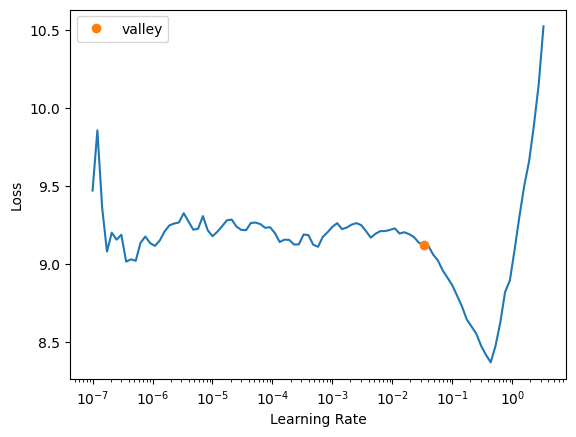

In [14]:
learn = collab_learner(dls,n_factors =40,y_range =(1,10))
learn.lr_find()

In [15]:
learn.fit_one_cycle(5,5e-3,wd=0.1)

epoch,train_loss,valid_loss,time
0,7.285091,5.995150,00:01
1,2.428019,2.715307,00:01
2,1.619723,2.508803,00:01
3,1.302539,2.456211,00:01
4,1.270276,2.444293,00:01


In [16]:
g = df.groupby("title")['rating'].count()
top_books =g.sort_values(ascending=False).index.values[:1000]
top_books_ratings = [(t,g[t]) for t in top_books]

In [17]:
book_biases = learn.model.bias(top_books,is_item =True)
mean_ratings = df.groupby("title")["rating"].mean()

In [19]:
book_ratings = pd.DataFrame({"bias": book_biases.squeeze(),
                             "mean_rating": mean_ratings[top_books],
                              "title": top_books
                            })
print(" top 10 books according to model bias  ")
print(book_ratings.sort_values("bias",ascending=False).head(10))

print(" bottom 10 books according to model bias ")
print(book_ratings.sort_values('bias', ascending=True).head(10))
   

 top 10 books according to model bias  
                                                              bias  \
title                                                                
The Little Prince                                         0.432832   
Fast Food Nation: The Dark Side of the All-American Meal  0.409843   
84 Charing Cross Road                                     0.407065   
East of Eden (Oprah's Book Club)                          0.397611   
Ender's Game (Ender Wiggins Saga (Paperback))             0.396799   
Lolita (Vintage International)                            0.386290   
Harry Potter and the Sorcerer's Stone (Book 1)            0.384909   
Atlas Shrugged                                            0.380021   
Siddhartha                                                0.370029   
The Subtle Knife (His Dark Materials, Book 2)             0.364734   

                                                          mean_rating  \
title                                         

In [20]:
book_factors = learn.model.weight(top_books, is_item=True)
idx = np.where(top_books == 'The Hobbit : The Enchanting Prelude to The Lord of the Rings')[0][0]

In [22]:
 distances = nn.CosineSimilarity(dim=1)(book_factors, book_factors[idx][None])
sorted_indices = distances.argsort(descending=True)

In [23]:
print("\n--- Books Similar to 'The Hobbit' ---")
for i in sorted_indices[1:6]: # Skip the first one as it's the book itself
    print(top_books[i])


--- Books Similar to 'The Hobbit' ---
Harry Potter and the Goblet of Fire (Book 4)
A Wrinkle in Time
The Two Towers (The Lord of the Rings, Part 2)
A Wrinkle In Time
The Return of the King (The Lord of the Rings, Part 3)
